In [1]:
import json
import os
from flask import Flask, render_template, request
from flask_cors import CORS
from helpers.MySQLDatabaseHandler import MySQLDatabaseHandler
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD


In [2]:
with open("dataset/cmu.json", "r") as file:
    book_data = json.load(file)
    book_df = pd.DataFrame(book_data)
    book_df = book_df.drop_duplicates(subset="book_title", ignore_index=True)

with open("dataset/netflix.json", "r") as file:
    show_data = json.load(file)
    show_df = pd.DataFrame(show_data)
    show_df = show_df.drop_duplicates(subset="title", ignore_index=True)


In [3]:
def build_vectorizer(max_features, stop_words, max_df=0.8, min_df=10, norm="l2"):
    vectorizer = TfidfVectorizer(
        max_df=max_df,
        min_df=min_df,
        max_features=max_features,
        stop_words=stop_words,
        norm=norm,
    )
    return vectorizer


def title_idx_maker(db, ind):
    title_to_idx = {}
    idx_to_title = {}

    for index, row in enumerate(db):
        title_to_idx[row[ind].lower()] = index
        idx_to_title[index] = row[ind]
    return title_to_idx, idx_to_title


book_title_to_idx, book_idx_to_title = title_idx_maker(book_data, "book_title")
netflix_title_to_idx, netflix_idx_to_title = title_idx_maker(show_data, "title")

n_feats = 10000
doc_by_vocab = np.empty([len(book_data), n_feats])
tfidf_vec = build_vectorizer(n_feats, "english")
doc_by_vocab = tfidf_vec.fit_transform(
    [row["plot_summary"] for index, row in enumerate(book_data)]
).toarray()
index_to_vocab = {i: v for i, v in enumerate(tfidf_vec.get_feature_names_out())}

query_by_vocab = np.empty([len(show_data), n_feats])

query_by_vocab = tfidf_vec.transform(
    [row["description"] for index, row in enumerate(show_data)]
).toarray()

SVD time!!
---
Approach 1: 
1. Fit SVD on book dataset
2. Transform both movie and book datasets


In [4]:
svd = TruncatedSVD(n_components=10, n_iter=10, random_state=42)

In [5]:
trained_svd = svd.fit(doc_by_vocab)

In [6]:
svd_books = trained_svd.transform(doc_by_vocab)
svd_netflix = trained_svd.transform(query_by_vocab)

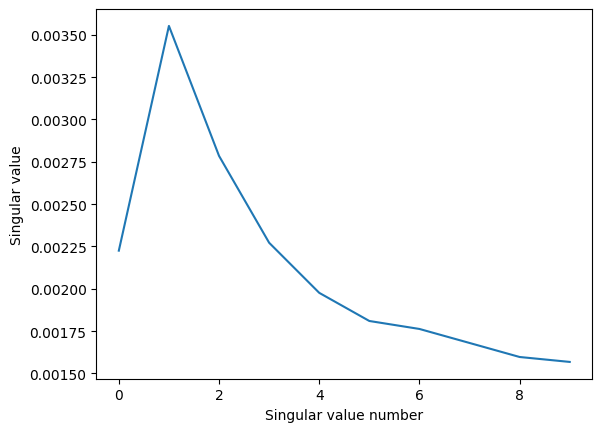

In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(trained_svd.explained_variance_ratio_)
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()


In [8]:
#This is how you access compressed words trained_svd.components_[:,4000].shape
reshaped_words = trained_svd.components_.T

In [9]:
from sklearn.preprocessing import normalize
compressed_terms = normalize(reshaped_words)

In [10]:
# cosine similarity
word_to_index = tfidf_vec.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]) for i in asort[1:]]

In [11]:
word = 'animal'
print("Using SVD:")
for w, sim in closest_words(word, compressed_terms):
  try:
    print("{}, {:.3f}".format(w, sim))
  except:
    print("word not found")
print()

Using SVD:
animals, 0.927
halloween, 0.924
feeding, 0.922
tiny, 0.922
eats, 0.917
eat, 0.914
daylight, 0.908
transforms, 0.907
egg, 0.904
branches, 0.904



In [12]:
import scipy
def get_sim_book(netflix_titles,book_mat):
    #if input is empty, replace input with a string
    if not netflix_titles:
        netflix_titles = [""]
    lower_titles=[a.lower() for a in netflix_titles]
    netflix_vectors=[]
    for lower_title in lower_titles:
        if lower_title in netflix_title_to_idx:
            netflix_idx = netflix_title_to_idx[lower_title]
            netflix_vec = svd_netflix[netflix_idx]
            netflix_vectors.append(netflix_vec)
      # TODO Fix this nonsense
        else:
            #return book_mat
            tf_idf_query= scipy.sparse.csr_matrix.toarray(tfidf_vec.transform([lower_title]))
            query_vec = trained_svd.transform(tf_idf_query).reshape(10,)
            print(f"{query_vec.shape=}")
            netflix_vectors.append(query_vec)
    avg_vector = np.mean(netflix_vectors, axis=0).reshape(1, -1)
    similarities = cosine_similarity(avg_vector, book_mat)
    return similarities


def book_sims_to_recs(book_sims, book_idx_to_title, book_mat):
    if np.array_equal(book_sims, book_mat):
        return [("This title is not in our database.", None)]
    else:
        sim_pairs = [(book_idx_to_title[i], sim) for i, sim in enumerate(book_sims[0])]
        top_5 = sorted(sim_pairs, key=lambda x: x[1], reverse=True)[:5]
        return top_5


def rec_books(netflix_title, book_mat, book_idx_to_title):
    assert book_mat is not None and book_idx_to_title is not None
    similarities = get_sim_book(netflix_title, book_mat)

    top_5 = book_sims_to_recs(similarities, book_idx_to_title, book_mat)
    # top_5_list = [tup[0] for tup in top_5]
    top_5_list = [tup for tup in top_5]
    print(f"{top_5_list=}")
    # matches = (book_data[top_5]).to_json(orient="records")
    # print(top_5)

    matches = json.dumps(top_5_list)

    print(f"The 5 most similar books to {netflix_title} are:")
    for index, (book_title, sim_score) in enumerate(top_5):
        print(f"\n{index+1}. {book_title}")
    return matches

In [13]:
rec_books([], svd_books, book_idx_to_title)

top_5_list=[('Animal Farm', 0.0), ('A Clockwork Orange', 0.0), ('The Plague', 0.0), ('An Enquiry Concerning Human Understanding', 0.0), ('A Fire Upon the Deep', 0.0)]
The 5 most similar books to [] are:

1. Animal Farm

2. A Clockwork Orange

3. The Plague

4. An Enquiry Concerning Human Understanding

5. A Fire Upon the Deep


'[["Animal Farm", 0.0], ["A Clockwork Orange", 0.0], ["The Plague", 0.0], ["An Enquiry Concerning Human Understanding", 0.0], ["A Fire Upon the Deep", 0.0]]'

In [17]:
for i in range(10):
    print("Top words in dimension", i)
    dimension_col = compressed_terms[:,i].squeeze()
    asort = np.argsort(-dimension_col)
    print([index_to_word[i] for i in asort[:20]])
    print()

Top words in dimension 0
['long', 'begins', 'moments', 'ends', 'secrecy', 'continues', 'passing', 'taking', 'surprisingly', 'end', 'takes', 'later', 'turned', 'insistence', 'worth', 'deciding', 'standing', 'halfway', 'warm', 'close']

Top words in dimension 1
['apollo', 'destruction', 'commonwealth', 'weaponry', 'brazil', 'destroyed', 'destroy', 'activated', 'populated', 'massive', 'cataclysm', 'zone', 'thor', 'rockets', 'wiped', 'mutated', 'unleash', 'constructed', 'destroying', 'thousands']

Top words in dimension 2
['1960s', '1940s', '1970s', '1920s', 'gradual', 'focuses', 'narratives', 'explores', 'portrays', 'interactions', 'opinions', '1973', '1960', 'contemporary', 'characteristic', 'parallels', 'central', 'themes', '1996', '1980s']

Top words in dimension 3
['egypt', 'reign', 'kings', 'princes', 'kingdom', 'famed', 'kingdoms', 'throne', 'monarch', 'persian', 'sultan', 'holy', 'marches', 'proclaimed', 'thebes', 'roman', 'pagan', 'rupert', 'king', 'judah']

Top words in dimension